In [3]:
import sys
sys.path.append('..')

import optimus

frequency = 500e3 # 1MHz
a = 0.003 #3cm
D = 0.18 #18 cm
centroid_file='Data/default_random_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[-D, 0, 0], number_of_point_sources_per_wavelength=2, velocity=0.4)

sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(radius=7.5e-3, element_size=0.75e-3)
material_ext = optimus.material.load_material('muscle') #CAMBIE A MUSCULO POR ALPLA MUY BAJO EN WATER
material_int = optimus.material.load_material('bone (cortical)')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

x = source.centroid_locations[0, :]
y = source.centroid_locations[1, :]
z = source.centroid_locations[2, :]


import numpy as np
Nx = 201
Ny = 101
Nz = 101
# Zmax = 0.05 Nz=101 quizas menos
xmin, xmax, ymin, ymax, zmin, zmax = [-D, D, -0.05, 0.05, -0.05, 0.05]

In [3]:
%%time

from optimus.source.transducers import transducer_field

paso = zmax / 50
save_p = []

for i in range(Nz):
    zval = (50 - i) * paso #PROBAR distintos valores loop (bajar valores de Nx Ny)
    plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
    points = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        zval*np.ones(plot_grid[0].size)))
    
    inc_field = transducer_field(source, material_ext, points, verbose=False)
    incident_pressure = inc_field.pressure.reshape([Nx, Ny])
    
    incident_pressure_plot = optimus.postprocess.common.array_to_imshow(incident_pressure)
    save_p.append(incident_pressure_plot)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
CPU times: user 4h 35min 27s, sys: 1.32 s, total: 4h 35min 29s
Wall time: 35min 14s


In [1]:
save_p_2 = [np.abs(i) for i in save_p]
arr = np.array(save_p_2)
arr_reshaped = arr.reshape(arr.shape[0], -1)
np.savetxt('MUSCLE_IPP_abs.txt', arr_reshaped)

NameError: name 'save_p' is not defined

In [4]:
loaded_arr = np.loadtxt("MUSCLE_IPP_abs.txt")

IPP_abs = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 201, 201)

In [5]:
c_0 = material_ext.speed_of_sound #bien
rho_0 = material_ext.density #bien
C_t = material_ext.heat_capacity #/ 1000 #DIVIDIRRRR
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b #attenuation_pow_b
#P = incident_pressure_plot.copy()
alpha_0 = material_ext.attenuation_coeff_a # Np/m
#alpha_0 = material_ext.attenuation_coeff_a * 8.69 # dB/m

In [6]:
%%time

I = (IPP_abs)**2 / (c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
Q = I.copy()
Q = 2 * alpha * I

CPU times: user 82.3 ms, sys: 51.4 ms, total: 134 ms
Wall time: 130 ms


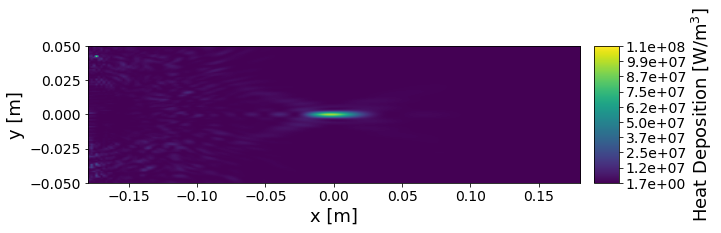

In [27]:
# PLOT Q
from optimus.postprocess.plot import surface_plot

theta = np.linspace(0, 2*np.pi, 100)
edge_sphere = (geometry.origin[0] + geometry.radius * np.cos(theta),
               geometry.origin[1] + geometry.radius * np.sin(theta))

T_test = Q[50]
fig = surface_plot(T_test,
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_test),np.max(T_test)],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

In [12]:
delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz
delta_t = 10e-3 #milisegundos #100 puntos por pulso

t_0 = 37

T_0 = np.zeros_like(Q) + t_0

aux = T_0.copy()

In [20]:
def next_it_numpy(T, Q): #ANADIR FUNCION PARA AMORTIGUAR Q
    T_ret = np.zeros_like(T) + t_0
    A = 1 - 2 * delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))
    B = delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2))
    C = delta_t * k_t / (rho_0 * C_t) * (delta_y ** (-2))
    D = delta_t * k_t / (rho_0 * C_t) * (delta_z ** (-2))
    E = delta_t / (rho_0 * C_t)
    T_ret[1:Nz-1, 1:Ny-1, 1:Nx-1] = (Q[1:Nz-1, 1:Ny-1, 1:Nx-1] * E +
                             T[1:Nz-1, 1:Ny-1, 1:Nx-1] * A +
                             (T[1:Nz-1, 1:Ny-1, 0:Nx-2] + T[1:Nz-1, 1:Ny-1, 2:Nx]) * B + 
                             (T[1:Nz-1, 0:Ny-2, 1:Nx-1] + T[1:Nz-1, 2:Ny, 1:Nx-1]) * C +
                             (T[0:Nz-2, 1:Ny-1, 1:Nx-1] + T[2:Nz, 1:Ny-1, 1:Nx-1]) * D
                        )
    return T_ret

In [14]:
Q[1,1,1] * delta_t / (rho_0 * C_t)

0.0059805618559371125

In [15]:
1 - 2 * delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))

0.9937587872045958

In [19]:
 37 * delta_t * k_t / (rho_0 * C_t) * (delta_z ** (-2))

0.05007926496664309

In [24]:
%%time
Q_0 = np.zeros_like(Q)
temps = [T_0]
for i in range(50):
    temps.append(next_it_numpy(temps[-1], Q))
    
for i in range(50):
    temps.append(next_it_numpy(temps[-1], Q))

CPU times: user 13.3 s, sys: 78.6 ms, total: 13.4 s
Wall time: 13.4 s


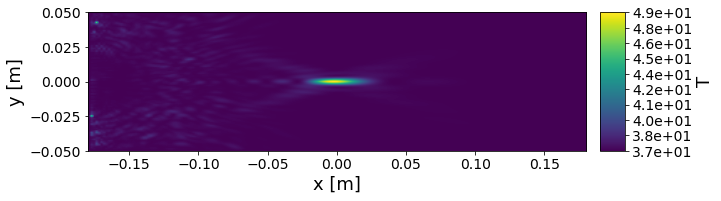

In [22]:
T_test = temps[-1][50]
fig = surface_plot(T_test,
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_test),np.max(T_test)],
                   colorbar_unit="T",
                   )

In [17]:
T_test.shape

(101, 101, 201)

In [10]:
np.max(T_test)

63.206596127162776

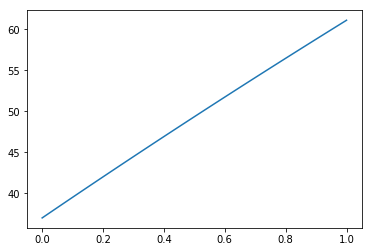

In [25]:
mid_x = Nx // 2
mid_y = Ny // 2
mid_z = Nz // 2

temp_mid = [temp[mid_z, mid_y, mid_x] for temp in temps]

tiempos = np.arange(100 + 1) * delta_t #CAMBIAR 100 por Nt

plt.plot(tiempos, temp_mid)

Buscar 43 grados o alrededores en foco. Cortar valores raros del Q.